In [5]:
# adapted from https://github.com/stackhpc/ansible-slurm-appliance/blob/main/ansible/roles/hpctests/files/plot_imb_pingpong.py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import os
import sys

def sizeof_fmt(num, suffix='B'):
    """ TODO: """
    # from https://stackoverflow.com/a/1094933/916373
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def read_imb_out(path):
    """ Read stdout from an IMB-MPI1 run.
        
        Returns a dict with:
            key:= int, total number of processes involved
            value:= pandas dataframe, i.e. one per results table. Columns as per table.
        
        If multiple results tables are present it is assumed that they are all the same benchmark,
        and only differ in the number of processes.
    """

    data = {}

    COLTYPES = { # all benchmark names here should be lowercase
        'uniband': (int, int, float, int), # #bytes #repetitions Mbytes/sec Msg/sec
        'biband': (int, int, float, int),
        'pingpong':(int, int, float, float), # #bytes #repetitions t[usec] Mbytes/sec
        'alltoall':(int, int, float, float, float) # #bytes #repetitions t_min[usec] t_max[usec] t_avg[usec]
    }

    with open(path) as f:
        for line in f:
            if line.startswith('# Benchmarking '):
                benchmark = line.split()[-1].lower()
                if benchmark not in COLTYPES:
                    raise ValueError('Do not know how to read %r benchmark in %s' % (benchmark, path))
                converters = COLTYPES[benchmark]
                line = next(f)
                if not line.startswith('# #processes = '):
                    raise ValueError('expected %s, got %s' % (expect, nprocs_line))
                n_procs = int(line.split('=')[-1].strip())
                while line.startswith('#'):
                    line = next(f) # may or may not include line "# .. additional processes waiting in MPI_Barrier", plus other # lines
                rows = []
                while True:
                    line = next(f).strip()
                    if line == '':
                        break
                    rows.append([f(v) for (f, v) in zip(converters, line.split())])
                # turn data around:
                cols = [[] for _ in range(len(converters))]
                for r in rows:
                    for ic, c in enumerate(cols):
                        c.append(r[ic])
                data[n_procs] = cols
    return data


def plot_imb_pong(path):
    d = read_imb_out(path)
    if len(d) > 1:
        raise ValueError('Found > 1 benchmark in', sys.argv[1])
    for n, df in d.items():
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(df[0], df[2], label='latency', color='b')
        ax2.plot(df[0], df[3], label='bandwidth', color='r')
        ax1.set_xscale('log', base=2)
        ax1.set_yscale('log', base=10)
        ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sizeof_fmt(x)))
        ax1.grid(True, which="both")
        ax1.set_xlabel('#bytes')
        ax1.set_ylabel('latency ($\mu$s)', color='b')
        ax2.set_ylabel('bandwidth (Mbytes/sec)', color='r')
        fig.legend(loc='upper left')
        plt.tight_layout()
    return d

zero-message latency: 22.15 us
max bandwidth: 2555.1 Mbytes/s


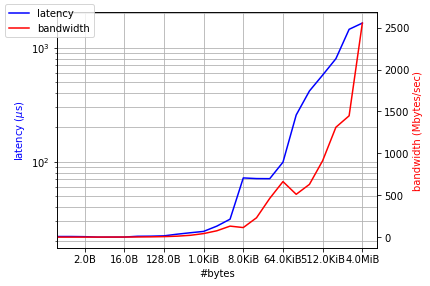

In [9]:
df = plot_imb_pong('slurm-44239758.out')

print('zero-message latency:', df[2][2][0], 'us') # 2 procs, cols: bytes #repetitions t[usec] Mbytes/sec
print('max bandwidth:', max(df[2][3]), 'Mbytes/s')

